## **Analyze A/B Test Results**


In this project, we use statistical methods to rate the preference over new page over old page using click through probabilities

We approach this problem using A/B testing.





<a id='intro'></a>
### **Problem Statement**

Analyze the results of an A/B test run by an e-commerce website.  The goal is to understand statistical methods to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decisions






### **Part I - Probability**

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


#### **Read the user_data.csv**

In [69]:
# read data
df = pd.read_csv('/content/drive/MyDrive/Implementing_new_page_over_old_page/user_data.csv')

#### **Shape of the dataset**

In [70]:
# check rows with shape method
df.shape

(294478, 5)

In [71]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [72]:
# info helps to get an overview as well
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### **Describing the data**

In [73]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


#### **Number of unique users in the dataset**

In [74]:
# use unique method
users_unique = df.user_id.nunique()
users_unique

290584

#### **Proportion of users that are converted**

In [75]:
# proportions of user who converted (i.e. converted = 1)

df.converted.mean()

0.11965919355605512

#### **The number of times the `new_page` and `treatment` don't line up.**

In [76]:
# there are two dimensions to this 
# 1. get the number where landing_page equals new_page but group is not treatment
# 2. get the number where landing_page not new_page but group is treatment
# adding these two will give total misalignment
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

#### **Checking for missing values**

In [77]:
# we find the rows with missing values with isnull
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.   



In [78]:
# using the same logic from e.
df_filtered = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [79]:
# Double Check all of the correct rows were removed - this should be 0
df_filtered[((df_filtered['group'] == 'treatment') == (df_filtered['landing_page'] == 'new_page')) == False].shape[0]

0

#### **How many unique user_ids are in df_filtered**

In [80]:
# check for info
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [81]:
df_filtered.user_id.nunique()

290584

**The size looks like there is one duplicate user id**

#### **Identifying duplicate user ID**

In [82]:
# here we look for duplicated user_id, but we show both of those in our result by keep=False
df_filtered[df_filtered.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [83]:
# we can remove duplicates in multiple ways
# removing by index, removing by first or last entry as well as by unique column timestamp
df_filtered = df_filtered[df_filtered.timestamp != '2017-01-09 05:37:58.781806']

In [84]:
# quick sanity check
df_filtered.user_id.nunique()

290584

## **A/B Test Implementation**

* Note that due to the time stamp associated with each event, it is technically possible to run a hypothesis test continuously as each observation is observed. However, the difficult part is determining when to stop the test and make a decision. In general, A/B tests require careful consideration of when to end the test and make a decision about which page is better.

* If we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses can be stated as follows:


.

**Null Hypothesis:** The conversion rate for the old page is greater than or equal to the conversion rate for the new page.

**Alternative Hypothesis:** The conversion rate for the new page is greater than the conversion rate for the old page.

In terms of pold and pnew, these hypotheses can be expressed as:

$$ H_{0} : p_{old} - p_{new} \geq 0$$
$$ H_{A} : p_{old} - p_{new} < 0$$

Assuming that pnew and pold both have "true" success rates equal to the converted success rate regardless of page, and that they are equal to the converted rate in user_data.csv, we can use a sample size for each page equal to the ones in user_data.csv.








* To perform the sampling distribution for the difference in conversion rates between the two pages over 20,000 iterations of calculating an estimate from the null, we can use a simulation approach. 

* Specifically, we can randomly sample from the combined data set (i.e., user_data.csv) and calculate the difference in conversion rates between the two pages. We can repeat this process 20,000 times to generate a sampling distribution for the difference in conversion rates between the two pages under the null hypothesis.


## **What is the convert rate for $p_{new}$ under the null?** 

In [85]:
# convert rate is how many users converted (i.e. converted = 1)
p_new = df_filtered.converted.mean()
p_new

0.11959708724499628

##  **What is the convert rate for $p_{old}$ under the null? <br><br>**

In [86]:
p_old = df_filtered.converted.mean() # the same!!!
p_old

0.11959708724499628

## **What is $n_{new}$?**

In [87]:
# number of users who got the new page (i.e. group = treatment)
n_new = df_filtered[df_filtered.group == 'treatment'].count()[0]
n_new

145310

##  **What is $n_{old}$?**

In [88]:
# number of users who reamined with old page (i.e. group = control)
n_old = df_filtered[df_filtered.group == 'control'].count()[0]
n_old

145274

## **Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in new_page_converted.**

In [89]:
# simulating n_new transaction that have probabiliy of receiving new page, using binomial gives the outout as the number of 1's
new_page_converted = np.random.binomial(1,p_new,n_new) 
new_page_converted.mean()

0.12138875507535614

In [90]:
# alternatively
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
new_converted_simulation.mean()

0.11960553712752048

## **Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in old_page_converted.**

In [91]:
# simulating n_new transaction that have probabiliy of having old page, using binomial gives the outout as the number of 1's
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11938130704737256

In [92]:
# alternatively
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
old_converted_simulation.mean()

0.11959268829935156

## **Find $p_{new}$ - $p_{old}$ value**

In [93]:
# probabilty of new and old page based upon simulated values in e. and f.
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_new - p_old

0.0020074480279835827

In [94]:
# alternatively
new_converted_simulation.mean() - old_converted_simulation.mean()

1.2848828168918192e-05

## **Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts a. through g. above.  Store all 10,000 values in p_diffs.**

In [95]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)  # bootstrapping
    old_page_converted = np.random.binomial(1,p_old,n_old) # bootstrapping
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [96]:
# alternatively
p_diffs_alt = new_converted_simulation - old_converted_simulation

## **Histogram of the p_diffs.**  

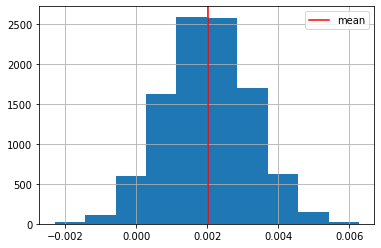

In [97]:
# convert p_diffs to numpy array for array based computations in the future
p_diffs = np.array(p_diffs)

# histogram
plt.hist(p_diffs)
plt.grid()
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend();

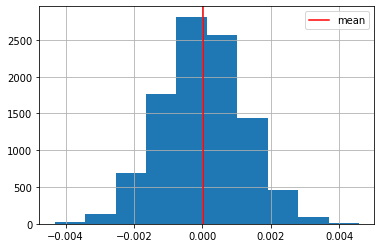

In [98]:
# alternatively
# histogram
plt.hist(p_diffs_alt)
plt.grid()
plt.axvline(p_diffs_alt.mean(), color='r', label='mean')
plt.legend();

As expected the mean is very close to 0. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **user_data.csv**?

In [99]:
actual_diff = df_filtered.converted[df_filtered.group == 'treatment'].mean() - df_filtered.converted[df_filtered.group == 'control'].mean()
(actual_diff < p_diffs).mean()

0.9982

In [100]:
# alternatively
actual_diff = df_filtered.converted[df_filtered.group == 'treatment'].mean() - df_filtered.converted[df_filtered.group == 'control'].mean()
(actual_diff < p_diffs_alt).mean()

0.9048

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


- **p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.**
- **In our case the p-value is so big that we can confidently say that we fail to reject null hypothesis**

## **BUILT-IN Method**

We could also use a built-in to achieve similar results.  

In [101]:
# quick check before diving in
df_filtered.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [102]:
import statsmodels.api as sm

convert_old = df_filtered[df_filtered.group == 'control'].converted.sum()
convert_new = df_filtered[df_filtered.group == 'treatment'].converted.sum()
n_old = df_filtered[df_filtered.group == 'control'].converted.count()
n_new = df_filtered[df_filtered.group == 'treatment'].converted.count()

## **Using `stats.proportions_ztest` to compute your test statistic and p-value.** 

In [103]:
# based upon the documentation
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

- **A z-score represents how many standard deviations away our data point is from the mean**
- **A positive z-score suggests that our data point is on the right side of the mean line on the bell curve**
- **p-value of 0.9050 is very close to the p-value we computed earlier in part j.**
- **With this computation, we can confidently say we fail to reject null hypothesis**


## **Closing marks**

Within this project, I tried to understand whether the company should implement a new page or keep the old page with A/B test




**A/B test:**
  - In A/B test we set up our hypothesis to test if new page results in better conversion or not
  - We simulated our user groups with respect to conversions
  - We found the p_value to be 0.8879
  - With such a p-value, we failed to reject null hypothesis
  - By using the built-in `stats.proportions_ztest` we computed z-score and p-value which confirmed our earlier p-value and failure to reject null hypothesis
  

  
**Conclusion**
  - We also looked at the duration of the experiment (21 days). 
  - This is a relatively short period of time to run the A/B test.
  - Due to Change aversion effect, a group of users may give an unfair advantage to the older page
  - Similarly, due to Novelty effect, users may give an unfair advantage to the newer page